In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from AnalyticFormulas import MertonJumpDiffusionPrice
from sklearn.model_selection import train_test_split, GridSearchCV #, RandomizedSearchCV
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from math import ceil

## Option Prices

In [26]:
data = pd.read_csv('msft-options-exp-2023-01-20-monthly-show-all-stacked-ohlc-01-05-2022.csv', thousands=',')
#data = pd.read_csv('bntx-options-exp-2023-01-20-show-all-stacked-ohlc-01-05-2022.csv', thousands=',')
#data = pd.read_csv('tsla-options-exp-2023-01-20-show-all-stacked-ohlc-01-05-2022.csv', thousands=',')
data = data[data['Type'] == 'Call'][['Strike', 'Open', 'High', 'Low', 'Last']]
#s =  # TSLA
s = 325.86 # MSFT
T = 380 / 365
data['Moneyness'] = s / data['Strike']
data['Normalized Prices'] = data['Open'] / data['Strike']
data.head()

,Strike,Open,High,Low,Last,Moneyness,Normalized Prices
0,105.0,228.50,229.0,228.50,229.00,3.103429,2.176190
1,110.0,216.90,216.9,216.90,216.90,2.962364,1.971818
2,115.0,224.65,225.2,224.50,225.00,2.833565,1.953478
3,120.0,223.70,223.7,223.69,223.69,2.715500,1.864167
4,125.0,199.50,199.5,199.50,199.50,2.606880,1.596000


In [27]:
data.describe()

,Strike,Open,High,Low,Last,Moneyness,Normalized Prices
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,292.000000,82.713600,82.842533,81.156533,81.661867,1.334148,0.469047
std,112.433163,70.543489,70.524233,71.094768,70.888828,0.624794,0.563131
min,105.000000,2.220000,2.350000,1.980000,2.210000,0.626654,0.004269
25%,197.500000,17.935000,18.075000,16.650000,17.470000,0.851958,0.046635
50%,290.000000,62.380000,62.380000,59.500000,60.970000,1.123655,0.215621
75%,382.500000,141.775000,141.775000,141.775000,141.775000,1.650188,0.709209
max,520.000000,228.500000,229.000000,228.500000,229.000000,3.103429,2.176190


<AxesSubplot:title={'center':'MSFT Call Prices'}, xlabel='Strike'>

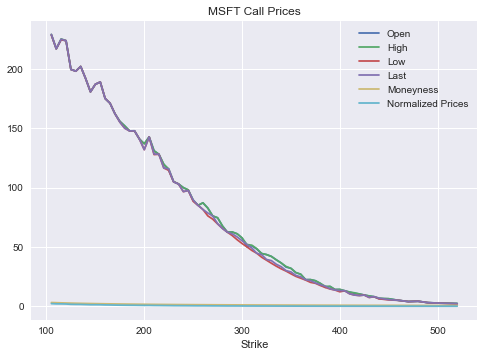

In [28]:
data.plot(x='Strike', title='MSFT Call Prices')

<AxesSubplot:title={'center':'MSFT Normalized Call Prices'}, xlabel='Moneyness'>

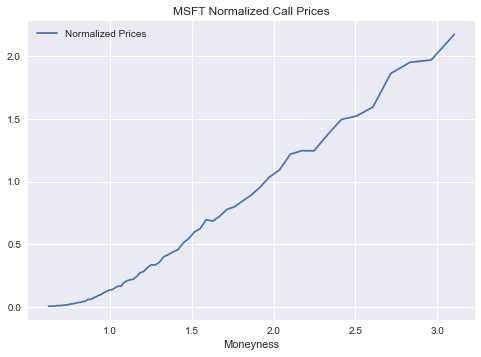

In [29]:
data.plot(x='Moneyness', y='Normalized Prices', title='MSFT Normalized Call Prices')

## Neural Net

In [30]:
data_shuffled = data.sample(frac=1)
X = data_shuffled['Moneyness']
y = data_shuffled['Normalized Prices']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [31]:
def create_model(n_weights=1000, hidden_layers=1, learning_rate=0.001):
    # formulas derived from nWeights = sum (d(l-1)+1)*d(l) for all layers l with output dim d(l)
    if hidden_layers == 1: # 100% of neurons in first hidden layer
        neurons = [ceil((n_weights - 1) / 3)]
    elif hidden_layers == 2: # 70% / 30% split of neurons
        x = 1/7 * (np.sqrt(21 * n_weights + 79) - 10)
        neurons = list(map(ceil,[7/3 * x, x]))
    elif hidden_layers == 3: # 50% / 30% / 20% split
        x = 1/21 * (np.sqrt(84 * n_weights + 205) - 17)
        neurons = list(map(ceil, [5/2 * x, 3/2 * x, x]))
    else:
        raise Exception('Only 1, 2 or 3 layers allowed')
        
    model = Sequential([Dense(neurons[0], activation='relu', input_dim=1)])
    for n in neurons[1:]:
        model.add(Dense(n, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model


In [32]:
earlyStop = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

batch_size = [4, 8, 16, 32, 64]
learning_rate = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
hidden_layers = [1, 2, 3]
n_weights = [10, 30, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000]

p_grid = dict(n_weights=n_weights, hidden_layers=hidden_layers, batch_size=batch_size, learning_rate=learning_rate)
#p_grid = dict(n_weights=n_weights, batch_size=batch_size, learning_rate=learning_rate)

results = {}

model = KerasRegressor(create_model, epochs=5000, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=p_grid, n_jobs=-1, cv=5, verbose=1)
grid_result = grid.fit(X, y, callbacks=[earlyStop])
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))



Fitting 5 folds for each of 1155 candidates, totalling 5775 fits
Best: -0.0006113944749813527 using {'batch_size': 64, 'hidden_layers': 3, 'learning_rate': 0.005, 'n_weights': 300}


In [33]:
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.0006113944749813527 using {'batch_size': 64, 'hidden_layers': 3, 'learning_rate': 0.005, 'n_weights': 300}
-0.075588 (0.088508) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 10}
-0.002659 (0.002077) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 30}
-0.002630 (0.002848) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 60}
-0.002354 (0.002609) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 100}
-0.002364 (0.001932) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 300}
-0.171826 (0.163284) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 600}
-0.322164 (0.118664) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 1000}
-0.323442 (0.107828) with: {'batch_size': 4, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 3000}
-0.324558 (0.104954) with: {'batch_size': 4, 

In [34]:
columns = ['mean_fit_time', 'param_batch_size', 'param_hidden_layers', 'param_learning_rate', 'param_n_weights', 'mean_test_score', 'rank_test_score']
#columns = ['mean_fit_time', 'param_batch_size', 'param_learning_rate', 'param_n_weights', 'mean_test_score', 'rank_test_score']
result_df = pd.DataFrame(grid_result.cv_results_,)[columns]
result_df.columns = ['fit_time', 'batch_size', 'hidden_layers', 'learning_rate', 'n_weights', 'test_score', 'rank']
#result_df.columns = ['fit_time', 'batch_size', 'learning_rate', 'n_weights', 'test_score', 'rank']
result_df[['batch_size', 'hidden_layers', 'n_weights']] = result_df[['batch_size', 'hidden_layers', 'n_weights']].astype(int)
#result_df[['batch_size', 'n_weights']] = result_df[['batch_size', 'n_weights']].astype(int)
result_df['learning_rate'] = result_df['learning_rate'].astype('float')
result_df['test_score'] = -result_df['test_score']
result_df['actual_weights'] = result_df[['hidden_layers', 'n_weights']].apply(lambda x: create_model(x[1], x[0]).count_params(), axis=1)
#result_df['actual_weights'] = result_df['n_weights'].apply(lambda x: create_model(x).count_params())
result_df.head()

,fit_time,batch_size,hidden_layers,learning_rate,n_weights,test_score,rank,actual_weights
0,1.378314,4,1,0.1,10,0.075588,790,10
1,1.193610,4,1,0.1,30,0.002659,622,31
2,0.980378,4,1,0.1,60,0.002630,619,61
3,0.958836,4,1,0.1,100,0.002354,604,100
4,1.047598,4,1,0.1,300,0.002364,605,301


In [35]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fit_time        1155 non-null   float64
 1   batch_size      1155 non-null   int32  
 2   hidden_layers   1155 non-null   int32  
 3   learning_rate   1155 non-null   float64
 4   n_weights       1155 non-null   int32  
 5   test_score      1155 non-null   float64
 6   rank            1155 non-null   int32  
 7   actual_weights  1155 non-null   int64  
dtypes: float64(3), int32(4), int64(1)
memory usage: 54.3 KB


In [36]:
result_df.describe()

,fit_time,batch_size,hidden_layers,learning_rate,n_weights,test_score,rank,actual_weights
count,1155.000000,1155.000000,1155.00000,1155.000000,1155.000000,1155.000000,1155.000000,1155.000000
mean,7.233354,24.800000,2.00000,0.023800,4645.454545,4.657778,578.000000,4686.636364
std,9.609676,21.830543,0.81685,0.035191,8580.013687,123.870778,333.564087,8614.267442
min,0.954048,4.000000,1.00000,0.000100,10.000000,0.000611,1.000000,10.000000
25%,2.033762,8.000000,1.00000,0.000500,60.000000,0.000984,289.500000,65.000000
50%,2.762613,16.000000,2.00000,0.005000,600.000000,0.001996,578.000000,611.000000
75%,7.796750,32.000000,3.00000,0.050000,6000.000000,0.124019,866.500000,6001.000000
max,103.413651,64.000000,3.00000,0.100000,30000.000000,4168.051367,1155.000000,30244.000000


In [37]:
idx = result_df.groupby(['n_weights'])['test_score'].transform(min) == result_df['test_score']
best_results = result_df[idx].sort_values('n_weights')
best_results

,fit_time,batch_size,hidden_layers,learning_rate,n_weights,test_score,rank,actual_weights
66,39.928224,4,1,0.0001,10,0.002218,594,10
716,3.066599,32,1,0.0100,30,0.000872,208,31
970,26.687632,64,1,0.0010,60,0.000841,177,61
971,30.162740,64,1,0.0010,100,0.000665,19,100
1115,12.433950,64,3,0.0050,300,0.000611,1,324
643,2.226447,16,3,0.0100,600,0.000618,3,611
963,23.390848,64,1,0.0050,1000,0.000635,5,1000
986,33.407063,64,1,0.0005,3000,0.000643,8,3001
349,2.118733,8,2,0.0050,6000,0.000642,7,6133
339,1.876980,8,2,0.0100,10000,0.000614,2,10181


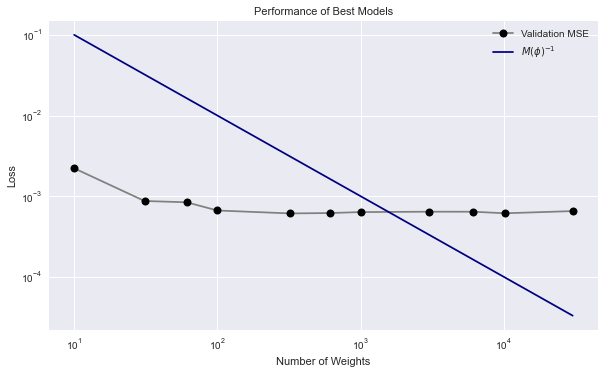

In [38]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8.5,5.3))
ax.plot(best_results['actual_weights'], best_results['test_score'], '-o', c='gray', mfc='k', mec='k', markersize=8, label='Validation MSE')
ax.plot(best_results['actual_weights'], 1 / best_results['actual_weights'], c='navy', label='$M(\phi)^{-1}$')
ax.set_xlabel('Number of Weights')
ax.set_ylabel('Loss')
ax.set_title('Performance of Best Models', fontsize=11)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
plt.tight_layout()

In [39]:
result_df.to_csv('grid_search_MSFT_Data_20220112_2.csv')

In [40]:
overview = best_results.drop(['actual_weights', 'rank'], axis=1)
overview = overview[['n_weights', 'hidden_layers', 'test_score', 'learning_rate', 'batch_size', 'fit_time']]
#overview.set_index('n_weights', inplace=True)
overview.columns = ['Weights', 'Hidden Layers', 'Validation MSE', 'Learning Rate', 'Batch Size', 'Training Time (s)']
overview['Validation MSE'] = overview['Validation MSE'].apply(lambda x: '{:.2e}'.format(x))
overview['Learning Rate'] = overview['Learning Rate'].apply(lambda x: '{:g}'.format(x))
overview['Training Time (s)'] = overview['Training Time (s)'].apply(lambda x: '{:.2f}'.format(x))
overview

,Weights,Hidden Layers,Validation MSE,Learning Rate,Batch Size,Training Time (s)
66,10,1,2.22e-03,0.0001,4,39.93
716,30,1,8.72e-04,0.01,32,3.07
970,60,1,8.41e-04,0.001,64,26.69
971,100,1,6.65e-04,0.001,64,30.16
1115,300,3,6.11e-04,0.005,64,12.43
643,600,3,6.18e-04,0.01,16,2.23
963,1000,1,6.35e-04,0.005,64,23.39
986,3000,1,6.43e-04,0.0005,64,33.41
349,6000,2,6.42e-04,0.005,8,2.12
339,10000,2,6.14e-04,0.01,8,1.88


In [41]:
print(overview.to_latex(index=False))

\begin{tabular}{rrllrl}
\toprule
 Weights &  Hidden Layers & Validation MSE & Learning Rate &  Batch Size & Training Time (s) \\
\midrule
      10 &              1 &       2.22e-03 &        0.0001 &           4 &             39.93 \\
      30 &              1 &       8.72e-04 &          0.01 &          32 &              3.07 \\
      60 &              1 &       8.41e-04 &         0.001 &          64 &             26.69 \\
     100 &              1 &       6.65e-04 &         0.001 &          64 &             30.16 \\
     300 &              3 &       6.11e-04 &         0.005 &          64 &             12.43 \\
     600 &              3 &       6.18e-04 &          0.01 &          16 &              2.23 \\
    1000 &              1 &       6.35e-04 &         0.005 &          64 &             23.39 \\
    3000 &              1 &       6.43e-04 &        0.0005 &          64 &             33.41 \\
    6000 &              2 &       6.42e-04 &         0.005 &           8 &              2.12 \